In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
from tqdm import tqdm

In [3]:
def load_image(image_path):
    image = Image.open(image_path)
    return image

def show_image_with_bounding_box(image, label, thickness=2):
    xc, yc, w, h = label
    w, h = w * image.width, h * image.height
    image = image.copy()
    ImageDraw.Draw(image).rectangle([(xc - w / 2, yc - h / 2), (xc + w / 2, yc + h / 2)], outline='red', width=thickness)
    plt.imshow(image)

In [4]:
class Resize:
    def __init__(self, new_size=(256, 256)):
        self.new_width = new_size[0]
        self.new_height = new_size[1]
        
    def __call__(self, image_label_sample):
        image, label = image_label_sample
        xmin, ymin, xmax, ymax = label
        original_width, original_height = image.size
        
        image = tf.resize(image, (self.new_height, self.new_width))
        xmin = xmin * self.new_width / original_width
        ymin = ymin * self.new_height / original_height
        xmax = xmax * self.new_width / original_width
        ymax = ymax * self.new_height / original_height
        
        return image, (xmin, ymin, xmax, ymax)
    
class ToTensor:
    def __call__(self, image_label_sample):
        image, label = image_label_sample
        image = tf.to_tensor(image)
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label
    
class ToPILImage:
    "Convert a tensor image to PIL image"
    def __init__(self, unscale_label=True):
        self.unscale_label = unscale_label
        
    def __call__(self, image_label_sample):
        image, label = image_label_sample
        label = label.tolist()
        
        image = tf.to_pil_image(image)
        
        return image, label

In [5]:
class TumorsDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_path, label = self.data_list.iloc[idx]
        image = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 26 * 26, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.fc = nn.Linear(256, 4)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
def fix_label(label, img_size):
    x, y, w, h = label
    w = w / img_size[0]
    h = h / img_size[1]
    return x, y, w, h

In [9]:
def read_dataset(data_dir):
    data_list = pd.DataFrame(columns=['image_path', 'label'])
    img_dir = os.path.join(data_dir, 'images')
    for root, _, files in os.walk(img_dir):
        for i, file in enumerate(files):
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                label_name = image_path.replace('.jpg', '.txt')
                label_path = os.path.join(data_dir, 'labels', label_name.split('/')[-1] )
                with open(label_path, 'r') as f:
                    label = f.readline().strip().split()[1:]
                    label = [float(x) for x in label]
                    if len(label) == 0:
                        continue
                    label = fix_label(label, (224, 224))
                    data_list.loc[i] = [image_path, label]
                    
    return data_list

In [10]:
train_path = os.path.join(os.getcwd(), 'Clean', 'train')
test_path = os.path.join(os.getcwd(), 'Clean', 'test')

train_data_list = read_dataset(train_path)
test_data_list = read_dataset(test_path)

In [11]:
train_data_list.head()

,image_path,label
0,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(0.42805755395683454, 0.6742424242424242, 0.00..."
1,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(0.5, 0.2196969696969697, 0.002087615621788283..."
2,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(0.3669064748201439, 0.2159090909090909, 0.000..."
3,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(0.2733812949640288, 0.5909090909090909, 0.001..."
4,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(0.16546762589928057, 0.2537878787878788, 0.00..."


In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = TumorsDataset(train_data_list, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TumorsDataset(test_data_list, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
images, labels = next(iter(train_dataloader))
images.size(), labels.size()

(torch.Size([64, 3, 224, 224]), torch.Size([64, 4]))

In [14]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
print(model)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [15]:
epochs = 10
for epoch in tqdm(range(epochs)):
    for i, data in enumerate(train_dataloader):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Loss 0.16883812844753265
Epoch 0, Loss 0.021365486085414886


 10%|█         | 1/10 [1:08:10<10:13:38, 4090.98s/it]

Epoch 1, Loss 0.01907031610608101
Epoch 1, Loss 0.02158437669277191


 20%|██        | 2/10 [2:14:34<8:57:00, 4027.54s/it] 

Epoch 2, Loss 0.023187192156910896
Epoch 2, Loss 0.02036435157060623


 30%|███       | 3/10 [3:20:40<7:46:36, 3999.49s/it]

Epoch 3, Loss 0.021748671308159828


 30%|███       | 3/10 [4:04:09<9:29:42, 4883.16s/it]


KeyboardInterrupt: 

In [ ]:
def bbox_iou(box1, box2):
    # Calculate the coordinates of the intersection of the two boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate the area of the intersection
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the area of each box
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection / (box1_area + box2_area - intersection)

    return iou

model.eval()

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)

        # Calculate the IoU for each prediction
        ious = [bbox_iou(output, label) for output, label in zip(outputs, labels)]

        # Consider a prediction to be "correct" if its IoU is above 0.5
        correct = sum(iou > 0.5 for iou in ious)

print(f'Number of correct predictions: {correct}')

Number of correct predictions: 0


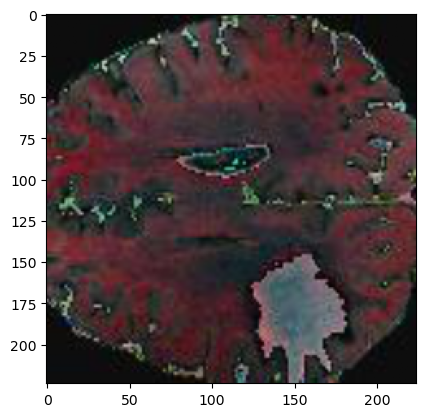

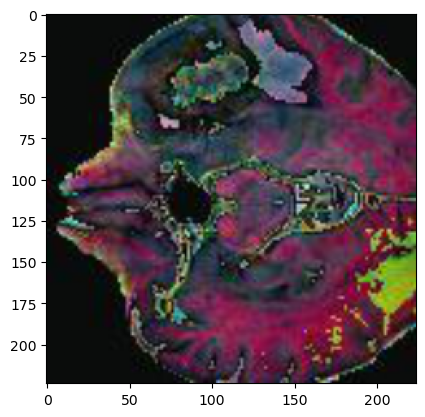

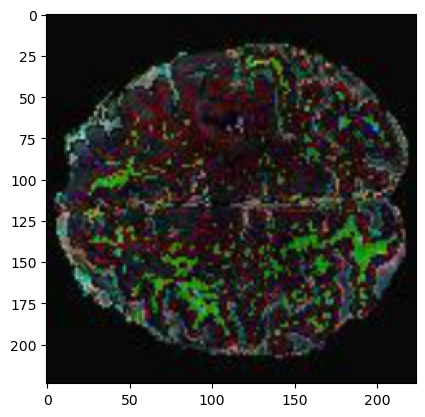

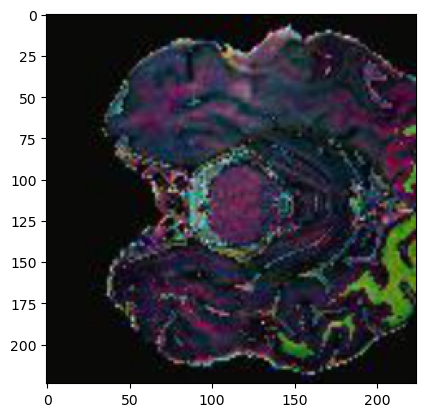

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image, true_box, pred_box):
    # Transpose the image from (C, H, W) to (H, W, C)
    image = image.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Create a Rectangle patch for the true bounding box
    rect_true = patches.Rectangle((true_box[0], true_box[1]), true_box[2], true_box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect_true)

    # Create a Rectangle patch for the predicted bounding box
    rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect_pred)

    plt.show()

model.eval()

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)

        # Plot the first image in the batch with true and predicted bounding boxes
        plot_image_with_boxes(images[0], labels[0], outputs[0])